# Society-based Cooperation - EVAC Assessment 2

## Design - Agent Representation

To begin with, each agent needs to be able to encode and store an evolvable strategy.

When defining an agents memory, there are $n^{2m}$ possible cases, where n is the number of societies types and m is the number of games each agent is allowed to remember. In this proposed solution, each agent will have a memory of 1 match, therefore there are $4^2=16$ possibilities.

The encoded strategy is simply a rule which specifies the action the agent should take in each of these 16 cases. In the context of this problem, the action to take is defined as the society the agent should switch to.

 An example subsection of this strategy is shown in the table below. 

| Memory              | Strategy (Society to switch to)       |
| ------------------  | ------------------------------------  |
| (Saint, Saint)      | Buddy                                 |
| (Saint, Buddy)      | Vandal                                |
| (Saint, Fight Club) | Saint                                 |
| (Saint, Vandal)     | Saint                                 |
| ...                 | ...                                   |
| (Vandal, Vandal)    | Fight Club                            |


This strategy can be expressed compactly as a list of length $4^2$ (e.g. `[Buddy, Vandal, Saint, Saint, ..., Fight Club]`). Therefore each agent must be able to find the index for the chromosome from the remembered match pairing.

Rather than generating a lookup table which maps society pairings to chromosome indexes, e.g. `{(Saint, Saint) = 0, (Saint, Buddy) = 1, ... (Vandal, Vandal) = 15}`, a faster method which also uses less memory is to map each society to a number between 0 and 3 and use the base 4 integer value of the pairing to access the chomosome. For example, with the assignments `{Saints: 0, Buddies: 1, Fight Club: 2, Vandals: 3}` the following indexes are obtained.

- (Saint, Saint) = $00_4$ maps to index 0
- (Saint, Buddy) = $01_4$ maps to index 1
- (Saint, Fight Club) = $02_4$ maps to index 2
- ...
- (Vandal, Vandal) = $33_4$ maps to index 15

**Summary**

To summarize, each agent will have a memory of 1 match, a pairing of the agents current faction and the opponent's faction. The base 4 representation of this matching will be used as the index to access the agents chromosome/strategy. This is represented as list of length 16 where each gene represents a society to switch to. 


## Code - Setup
The following code imports any libraries needed to run the genetic algorithm, including the Distributed Evolutionary Algorithms in Python (DEAP) library which is an evolutionary computation framework allowing for rapid prototyping and testing of ideas. 

NumPy and Matplotlib are used for statistical analysis and visualisation of the genetic algorithms performance.

A seed in the random module has been set to ensure the submitted PDF matches the provided colab notebook.

An Enum for the societies has also been defined so they can be easily referenced throughout the program. Each one is assigned a string value between 0 to 3 due to the explanation provided in **Design - Agent Representation**.

In [8]:
!pip install deap 

In [9]:
import random
import time

from deap import creator, base, tools
from collections import Counter
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

IND_SIZE = 4**2

random.seed(100)

class Society(Enum):
    """ Enum which represents all possible societies that agents can join"""
    SAINTS = "0"
    BUDDIES = "1"
    FIGHT_CLUB = "2"
    VANDALS = "3"

## Code - The Game
The following code is used for the main game logic. This plays a round, determines the outcomes and updates the agents as required. 

In [10]:
# Dictionary which maps society pairings to their respective payoff amounts. 
OUTCOMES = {
    # Saints cooperate with everyone
    (Society.SAINTS, Society.SAINTS):           (4,4), # Both cooperate
    (Society.SAINTS, Society.BUDDIES):          (0,6), # Buddies are selfish
    (Society.SAINTS, Society.FIGHT_CLUB):       (4,4), # Both cooperate
    (Society.SAINTS, Society.VANDALS):          (0,6), # Vandals are selfish

    # Buddies only cooperate with each other
    (Society.BUDDIES, Society.SAINTS):          (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.BUDDIES):         (4,4), # Both cooperate
    (Society.BUDDIES, Society.FIGHT_CLUB):      (6,0), # Buddies are selfish
    (Society.BUDDIES, Society.VANDALS):         (1,1), # Both selfish
    
    # Fight club cooperate with everyone but themselves
    (Society.FIGHT_CLUB, Society.SAINTS):       (4,4), # Both cooperate
    (Society.FIGHT_CLUB, Society.BUDDIES):      (0,6), # Buddies are selfish
    (Society.FIGHT_CLUB, Society.FIGHT_CLUB):   (1,1), # Both selfish
    (Society.FIGHT_CLUB, Society.VANDALS):      (0,6), # Vandals are selfish
    
    # Vandals cooperate with no one
    (Society.VANDALS, Society.SAINTS):          (6,0), # Vandals are selfish
    (Society.VANDALS, Society.BUDDIES):         (1,1), # Both selfish
    (Society.VANDALS, Society.FIGHT_CLUB):      (6,0), # Vandals are selfish
    (Society.VANDALS, Society.VANDALS):         (1,1), # Both selfish
}

def play_round(indiv1, indiv2):
    '''Updates each individual depending on the outcome of the round played'''

    # Increments each individuals rounds_played attribute
    indiv1.rounds_played += 1
    indiv2.rounds_played += 1
    
    # Increases each individuals wealth by the appropriate payoff
    payoffs = OUTCOMES[(indiv1.society, indiv2.society)]
    indiv1.total_score += payoffs[0]
    indiv2.total_score += payoffs[1]

    # Queries each agents chromosome using base 4 representations of the match to decide what society to switch to.
    new_match = str(indiv1.society.value)+(indiv2.society.value)
    chr1_index = int(new_match, base=4)
    indiv1.society = Society(indiv1[chr1_index])
    chr2_index = int(new_match[::-1], base=4)
    indiv2.society = Society(indiv2[chr2_index])

## Design - Adaption & Evolution
Using the previously defined agent strategy representation, the following genetic algorithm has been proposed to evolve this representation to maximise the agents total payoff over the course of the whole simulation.

### Population Generation
Firstly, a population needs to be generated. This is done by creating lists of length 16 and populating each of them randomly with societies. 

The population number chosen is 2000.

### Evaluation & Fitness
For every generation of the algorithm, including the first population, all agents needs to be evaluated to determine their fitness. 

For $N$ rounds, two agents are randomly selected and play each other. Each time agents play each other, their `rounds_played` attribute is incremented by 1, their `total_score` is increased by the relevant payoff, and they both change society depending on their chromosomes value for that matchup of societies.

Once the entire game is complete, the fitness for each agent needs to be calculated. As the game selects the agents who play each round completely randomly, there is likely to be an unfair difference between the total wealths of each agent. For example, an agent who has played 1 round and has a wealth of 6, should not have the same fitness as an agent who has played 6 rounds and also has a wealth of 6. 

Therefore, the fitness of each agent is defined by the agents total wealth divided by the number of rounds it has played. This is shown by the following function.

$fitness(agent) =  \frac{agent_{total\_score}}{agent_{rounds\_played}}$


### Selection

Once the fitnesses have been calculated for all agents, a new population needs to be selected. The method of selection used is tournament selection. This selects a specified number of agents and takes the one with the highest fitness value from the tournament and adds it to the new population. **The tournament size is set to  200**. A diagram showing this method of selection is provided below.

![](images/selection.png)

### Crossover
Crossover is then performed on the selected agents. The method of crossover selected is two point crossover where two points are picked randomly from the parent chromosomes. The societies in between the two points are swapped between the parent organisms. **The probability of this crossover occurring per agent is set to 0.15.** A diagram of an example of this crossover is provided below. 

![](images/crossover.png)

### Mutation
Mutation is then performed on the agents produced by the crossover step. The method of mutation chosen is the shuffle indexes method, where if a gene is chosen to be mutated, it is swapped with a random gene elsewhere in the chromosome. **The probability of this mutation occurring per gene is set to 0.05.** An example of this mutation is provided in the diagram below.

![](images/mutation.png)

### Population Reset & Re-evaluation
As the agents chromosomes have been changed, their attributes must be reset and their fitnesses re-evaluated using the method described previously. This process then occurs for a defined number of generations. **The number of generations has been set to 200.** A flowchart showing the overall design of the procedure is provided below. 

![](images/flowchart.png)



## Code - Adaption & Evolution
The following code implements the design as mentioned previously. It generates the initial population, evaluates their fitness and performs selection, mutation and crossover over multiple generations.

In [11]:
def reset_population(population):
    '''Resets all agent's attributes prior to evaluation'''
    for indiv in population:
        indiv.total_score = 0
        indiv.rounds_played = 0
        indiv.society = random.choice(list(Society))
        indiv.history = "".join([random.choice([society.value for society in Society]) for i in range(2)])

def evaluate_agents(population, num_rounds):
    '''Runs the game and sets each agents fitness depending on the outcome'''
    for i in range(num_rounds):
        indiv1 = random.choice(population)
        indiv2 = random.choice(population)
        while indiv2 == indiv1:
            indiv2 = random.choice(population)
        play_round(indiv1, indiv2)
    
    for ind in population:
        if ind.rounds_played == 0:
            ind.fitness.values = 0,
        else:
            ind.fitness.values = ind.total_score / ind.rounds_played,

def run_GA(gen_num=200, pop_num=20, round_num=400, mut_prob=0.021, cx_prob=0.15, tourn_size=5, headless=True):
    '''Runs the genetic algorithm and returns the statistics from the run'''

    start_time = time.time()

    # Sets the fitness to maximise as each agent wants to maximise its income
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))

    # Defines class for each Individual with the chromosome as a list and fitness as maximizing. Also defines the attributes each agent will require. 
    creator.create("Individual", list, fitness=creator.FitnessMax, total_score=0, rounds_played=0, society=Society.SAINTS, history = "00")

    toolbox = base.Toolbox()

    # Registers function to create a gene with the value "0", "1", "2", "3" to represent each society.
    toolbox.register("attr_str", random.choice, [society.value for society in Society])

    # Registers function which creates an Individual with 16 random genes.
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_str, n = 16)

    # Registers function to select, crossover and mutate individuals
    toolbox.register("select", tools.selTournament, tournsize=tourn_size)
    toolbox.register("crossover", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mut_prob)

    # Registers the function to create a population as a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Regisers the manually created functions to evaluate and reset the population
    toolbox.register("evaluate", evaluate_agents)
    toolbox.register("reset_population", reset_population)

    # Registers the statistics & logbook that will be logged during the GA
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("mean", np.mean)
    stats.register("std", np.std)
    stats.register("median", np.median)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()

    # Creates initial population
    population = toolbox.population(pop_num)

    # Resets population to prevent bias as deap creates all agents with same society and history attributes. 
    toolbox.reset_population(population)

    # Evaluates the initial population
    toolbox.evaluate(population, round_num)

    # Initializes dictionary to count number of agent per society in each generation
    counts = {
        Society.SAINTS: [],
        Society.BUDDIES: [],
        Society.FIGHT_CLUB: [],
        Society.VANDALS: []
    }

    for g in range(gen_num):
        print(f"-- Running Generation {g+1}/{gen_num} --       ", end='\r')

        # Selects new population and clones all individuals due to duplicates.
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Performs crossover on 2 individuals based on crossover probability
        for indiv1, indiv2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.crossover(indiv1, indiv2)

        # Mutates offspring based on mutation probability
        for mutant in offspring:
            toolbox.mutate(mutant)
        
        # Resets agent attributes and fitness values
        toolbox.reset_population(offspring)

        # Recalculates fitness values for mutated offspring
        toolbox.evaluate(offspring, round_num)

        # Replaces old population with new mutated offspring
        population[:] = offspring

        # Compiles & records the statistics for the new generation
        record = stats.compile(population)
        logbook.record(gen=g, **record)
        assignments = [indiv.society for indiv in population]
        for society in Society:
            counts[society].append(assignments.count(society))
    
    print(f"\nExecution Time - {time.time()-start_time:.2f}s")

    return logbook, counts


In [12]:
lb, counts = run_GA(gen_num=200, pop_num=2000, round_num=10000, mut_prob=0.05, cx_prob=0.15, tourn_size=200, headless=True)

C:\Users\lucea\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\lucea\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Execution Time - 65.53s00/200 --       


## Design - Evaluation Procedure
Explain the evaluation procedure here

## Code - Evaluation Procedure 
The following code is used to perform the previously described evaluation procedure for the genetic algorithm against non-adaptive behaviour. 

In [13]:
def draw_graphs(logbook, counts):
    gens = logbook.select("gen")
    means = logbook.select("mean")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 8)
    fig.suptitle("Society Based Cooperation")

    ax1.set_title("Fitness Stats")
    ax1.plot(gens, means, lw=3, color="red")

    ax2.set_title("Assignment Counts")
    ax2.plot(gens, counts[Society.SAINTS], lw=2, color="green", label="Saints")
    ax2.plot(gens, counts[Society.BUDDIES], lw=2, color="lightblue", label="Buddies")
    ax2.plot(gens, counts[Society.FIGHT_CLUB], lw=2, color="orange", label="Fight Club")
    ax2.plot(gens, counts[Society.VANDALS], lw=2, color="red", label="Vandals")
    ax2.legend

    plt.show()

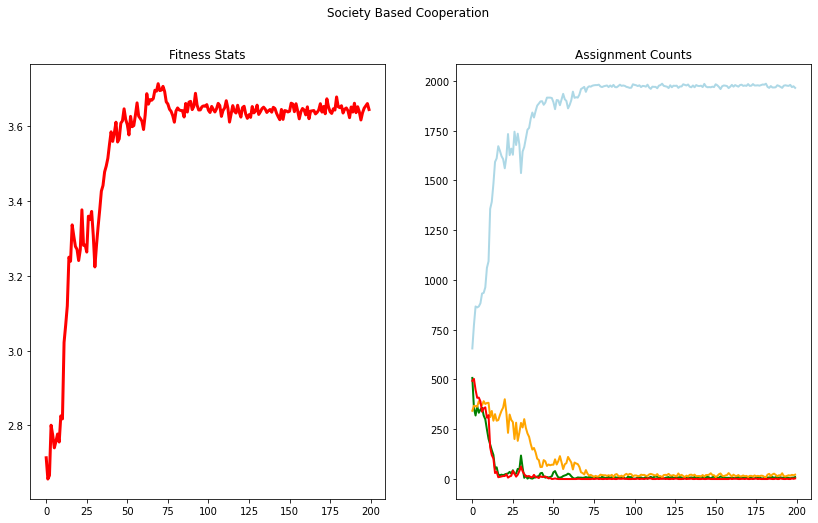

In [14]:
draw_graphs(lb, counts)